# TDEsMonteMetric


This notebook demonstrates how to use TDEsMonteMetric which calculates what fraction of an input TDE lightcurve would be detected. Paired with a spatial slicer, you can obtain the skymap or the observed light curve. 


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils

# import the metric from mafContrib
from mafContrib import TDEsMonteMetric

## Simulated TDE light curve and the minimum requirement

The TDEsAsciiMetric provides some prameters to meet the requirement of detection TDEs.

- nObsTotal: Required total number of observations in each band.
- nObsPrePeak: Required Number of observations before peak.
- nObsNearPeak: Required number of observations in each band near peak.
- nFiltersNearPeak: Required number of filters near peak.
- nObsPostPeak: Required number of observations in each band after peak.
- nFiltersPostPeak: Required number of number of filters after peak.

**Minimum requirement for detection TDEs** proposed by [Sjoert van Velzen](https://github.com/sjoertvv)

- one detection before peak in any band to make sure we can roughly resolve the time/flux at peak,  set nObsPrePeak=1;
- detections in three different bands within 10 days of peak to measure the color at peak, set nFiltersNearPeak=3, and nearPeakT=10;
- detections at least two bands post peak within two weeks to measure the change of color, set nFiltersPostPeak=2, and postPeakT=14.


**set parameters according to input lightcurve template and minimum requirement**

| parameters | value | meaning| 
| ---        | ---   |
| eventRate  | 0.2   |  Two events may occur per 10 days  |
| epochStart | -22   |  Start epoch of input light curve |
| peakEpoch  | 0     |  Peak epoch of input light curve  |
| nearPeakT  | 10    |  Within 10 days around peakEpoch are considered as near peak |
| postPeakT  | 14    |  Within two weeks after peakEpoch are considered as post peak |
| nObsTotal  |{'u': 0, ...}| Number of total observations in each band |
| nObsPrePeak| 1     | Number of observations before peak |
|nObsNearPeak |{'u': 0, ...}| Number of observations in each band near peak |
|nFiltersNearPeak | 3 | Number of filters near peak |
|nObsPostPeak | {'u':0, ...} | Number of observations in each band after peak |
|nFiltersPostPeak | 2 | Number of filters after peak |

one vists in u and r near peak 
one visits in u and r after peak within two weeks



In [34]:
# light curve file
asciifile = 'TDEfaintfast_z0.1.dat'

# query columns 
mjdCol = 'observationStartMJD'
m5Col = 'fiveSigmaDepth'
filterCol = 'filter'
detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}

eventRate = 0.5
# light curve parameters
epochStart = -22
peakEpoch = 0
nearPeakT = 10
postPeakT = 14 # two weeks

# condition parameters
nObsTotal = {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}
nObsPrePeak = 0
nObsNearPeak = {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}
nFiltersNearPeak = 3
nObsPostPeak = {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}
nFiltersPostPeak = 0


Let's plot the light curve template. 

In [36]:
# plot light curve
def plotlc(dataSlice, time_key='time', mag_key='mag', filter_key='filter', err_key = None,
          peakEpoch=None, nearPeakT=None, postPeakT=None):
    # Input: dataSlice, pandas DataFrame or numpy ndarray
    
    colors = {'u':'k', 'g':'b', 'r':'r', 'i':'m', 'z':'orange', 'y':'c'}
    
    plt.figure(figsize=(10, 6))
    for f in np.unique(dataSlice[filter_key]):
        fmatch = dataSlice[filter_key]==f
        time = dataSlice[time_key][fmatch]
        mag = dataSlice[mag_key][fmatch]
        
        # draw a vertical line to denote pre/near/post peak
        if peakEpoch!=None:
            plt.axvline(x=peakEpoch, linestyle='-', linewidth=1)
            plt.axvline(x=peakEpoch-nearPeakT/2, linestyle='--', linewidth=1)
            plt.axvline(x=peakEpoch+nearPeakT/2, linestyle='--', linewidth=1)
            plt.axvline(x=peakEpoch+nearPeakT/2+postPeakT, linestyle='--', linewidth=1)
        
        if err_key!=None:
            mag_err = dataSlice[err_key][fmatch]
            plt.errorbar(time, mag, yerr=mag_err, color=colors[f], fmt='.', label=f)
        else:
            plt.scatter(time, mag, color=colors[f], marker='*', label=f)

    plt.legend()
    plt.xlabel('days')
    plt.ylabel('mag')
    plt.ylim(plt.ylim()[::-1])

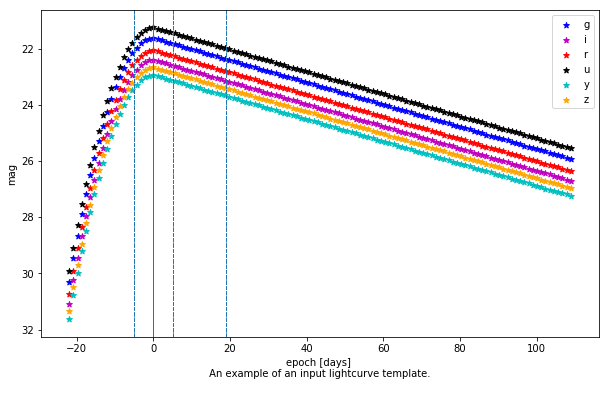

In [5]:
asciifile = 'TDEfaintfast_z0.1.dat'

lcv_template = np.genfromtxt(asciifile, dtype=[('ph', 'f8'), ('mag', 'f8'), ('flt', 'S1')])

df = pd.DataFrame()
df['ph'] = lcv_template['ph']
df['mag'] = lcv_template['mag']
df['flt'] = lcv_template['flt'].astype(str)

plotlc(df, time_key='ph', mag_key='mag', filter_key='flt', 
       peakEpoch=peakEpoch, nearPeakT=nearPeakT, postPeakT=postPeakT)

plt.xlabel('epoch [days] \n An example of an input lightcurve template. \n' )


## Opsim database

Connect to opsim database and get the proposalId

In [6]:
# connect to opsim database
opsdb_baseline = db.OpsimDatabase('./opsdb/baseline_2snap_v1.3_10yrs.db')
# opsdb_baseline.fetchPropInfo()

In [7]:
# output directory
outDir = 'outdir'
resultsDb = db.ResultsDb(outDir=outDir)


### get skymap

Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<600 and proposalId=3 for columns ['observationStartMJD', 'fieldDec', 'fiveSigmaDepth', 'fieldRA', 'filter']
Found 312003 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<600 and proposalId=3" constraint now.
monopole: 0.00627864  dipole: lon: 121.628, lat: -73.9947, amp: 0.0259101
Plotting complete.


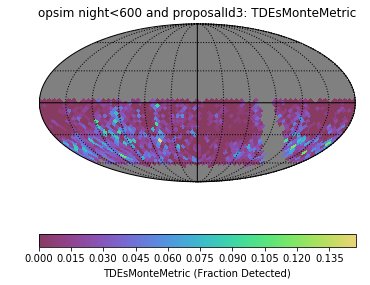

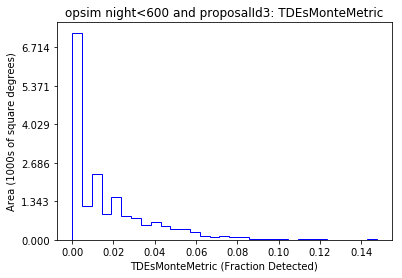

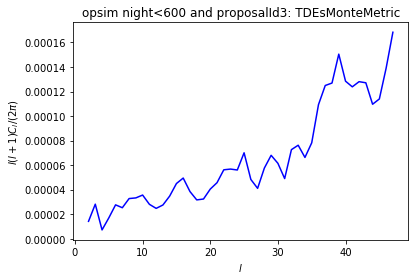

In [9]:
# get skymap by set dataout=False and use HealpixSlicer()
transmetric = TDEsMonteMetric(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                              detectSNR=detectSNR, eventRate=eventRate,
                              epochStart=epochStart, peakEpoch=peakEpoch, 
                              nearPeakT=nearPeakT, postPeakT=postPeakT,
                              nObsTotal= nObsTotal, nObsPrePeak=nObsPrePeak, 
                              nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                              nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                              dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<600 and proposalId=3'

transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_baseline, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)



We can create a pd.DataFrame and save the skymap info for later use.

In [11]:
baseline2018_skymap = transmetricSky.metricValues

# create a dataframe and save to csv file
df = pd.DataFrame(baseline2018_skymap)
df['ipix'] = df.index 
df['ra'] = hp.pix2ang(ipix=df['ipix'], nside=16, lonlat=True)[0]
df['dec'] = hp.pix2ang(ipix=df['ipix'], nside=16, lonlat=True)[1]
df['metricValues'] = df[0]
del df[0]
df.to_csv('./opsdb/baseline2018_skymap_TDEmc.csv', index=False, na_rep='NaN')

df.head()

,ipix,ra,dec,metricValues
0,0,45.0,87.075820,NaN
1,1,135.0,87.075820,NaN
2,2,225.0,87.075820,NaN
3,3,315.0,87.075820,NaN
4,4,22.5,84.149733,NaN


In [12]:
# view all metric values 
np.unique(baseline2018_skymap)

masked_array(data = [0.0 0.00684931506849315 0.0070921985815602835 0.007194244604316547
 0.007407407407407408 0.007518796992481203 0.007633587786259542
 0.007751937984496124 0.0078125 0.007874015748031496 0.007936507936507936
 0.008 0.008130081300813009 0.008264462809917356 0.008333333333333333
 0.008403361344537815 0.00847457627118644 0.008547008547008548
 0.008620689655172414 0.008695652173913044 0.008771929824561403
 0.008849557522123894 0.008928571428571428 0.009009009009009009
 0.00909090909090909 0.009174311926605505 0.009259259259259259
 0.009345794392523364 0.009433962264150943 0.009523809523809525
 0.009615384615384616 0.009708737864077669 0.00980392156862745
 0.009900990099009901 0.01 0.010101010101010102 0.01020408163265306
 0.010309278350515464 0.010416666666666666 0.010526315789473684
 0.010638297872340425 0.010752688172043012 0.010869565217391304
 0.01098901098901099 0.011111111111111112 0.011235955056179775
 0.011363636363636364 0.011494252873563218 0.011627906976744186


In [23]:
# get the all ipixes for a metric value
np.where(baseline2018_skymap.data>=0.1) 

/home/docmaf/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


(array([2408, 2443, 2497, 2568, 2683, 2724]),)

In [11]:
# get the (ra,dec) for a ipix
hp.pix2ang(ipix=2369, nside=16, lonlat=True)

(185.625, -32.797168295823639)

### get light curve 

In [8]:
## get light curve by set dataout=True and use UserPointSlicer()
transmetric = TDEsMonteMetric(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                              detectSNR=detectSNR, eventRate=eventRate,
                              epochStart=epochStart, peakEpoch=peakEpoch, 
                              nearPeakT=nearPeakT, postPeakT=postPeakT,
                              nObsTotal= nObsTotal, nObsPrePeak=nObsPrePeak, 
                              nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                              nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                              dataout=True)
# ra,dec of ipix 
ra = np.array([185.625])
dec = np.array([-32.79716])
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<400 '
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_baseline, outDir=outDir, resultsDb=resultsDb)
group.runAll()


Finish initializing metric
Querying database SummaryAllProps with constraint night<400  for columns ['observationStartMJD', 'fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth']
Found 227233 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


The output metricValues is a list of dictionaries for each light curve. Each dictionary contains arrays of 

|  variable   |  meaning   |
| --- | --- |
| 'lcN'| number of light curve, start from 0|
| 'lcMJD' | the time when the light curve occurs |
|'lcEpoch' | epoch of the light curve |
| 'm5'     | the fiveSigmaDepth |
|'lcFilters' | filters |
| 'lcMags'| magnitudes of the light curve|
| 'lcSNR' | signal to noise ratio|
| 'lcMagsStd'| standard deviation of magnitudes|
| 'lcAboveThresh'| equals True if for detected magnitudes|
| 'prePeakCheck' | equals True for prePeak observations |
| 'nearPeakCheck'| equals True for nearPeak observations|
| 'postPeakCheck'| equals True for postPeak observations|
| 'detected' | equals True if this light curve was detected|

In [9]:
# create a DataFrame from the output
output_dict_list = transmetricSky.metricValues.data[0] # 0 means 0th userpoint (ra,dec)
df = pd.DataFrame()
for d_ in output_dict_list:
    df = df.append(pd.DataFrame(d_))

# save to file
df.to_csv('./opsdb/baseline2018_lc_TDEmc.csv', index=False)
df.head()

,detected,lcAboveThresh,lcEpoch,lcFilters,lcMags,lcMagsStd,lcMjd,lcN,lcSNR,m5,nearPeakCheck,postPeakCheck,prePeakCheck
0,False,False,-20.988677,i,30.308523,4.718269,59942.356390,0,0.013133,23.856995,False,False,True
1,False,False,-19.991019,z,29.838923,5.154476,59943.354048,0,0.008750,22.946480,False,False,True
2,False,False,-16.043942,z,27.288803,3.153829,59947.301125,0,0.057933,22.448694,False,False,True
3,False,False,-15.990710,r,26.658316,1.417344,59947.354357,0,0.371852,23.836815,False,False,True
4,False,False,-15.008407,y,26.983524,2.864815,59948.336659,0,0.076962,22.451784,False,False,True


Let's see how many light curve occured and which light curve was detected. This may be different from the skymap, because light curves occurs randomly poisson distrubution. 

In [10]:
# total number of light curve
np.unique(df['lcN'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51])

In [11]:
# which light curve is detected
np.unique( df[df.detected]['lcN'] )

array([], dtype=int64)

Let's see what the detected light curve looks like by plotting use the same function defined above.

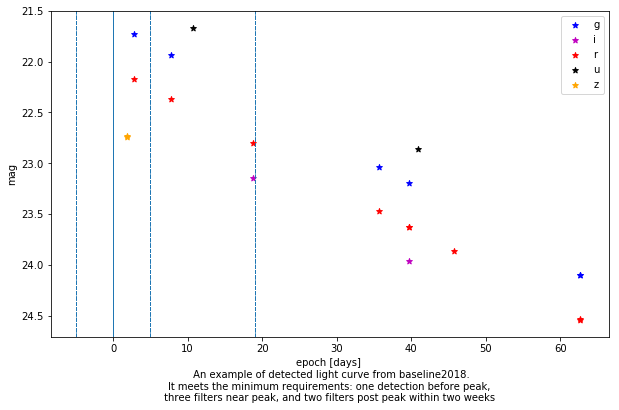

In [22]:
# load from csv
# df = pd.read_csv('./opsdb/baseline2018_lc.csv')

# plot all light curve
# plotlc(df[ (df['lcAboveThresh'])], time_key='expMJD', mag_key='lcMags', filter_key='filters', err_key='lcMagsStd')

# plot a specific light curve
plotlc(df[ (df.lcAboveThresh) & (df.lcN==3)], time_key='lcEpoch', mag_key='lcMags', filter_key='lcFilters', err_key=None, 
       peakEpoch=peakEpoch, nearPeakT=nearPeakT, postPeakT=postPeakT)

plt.xlabel('epoch [days] \n An example of detected light curve from baseline2018.\n' + 
           'It meets the minimum requirements: one detection before peak,\n three filters near peak, and two filters post peak within two weeks ')



What the non-detected light curve looks like.

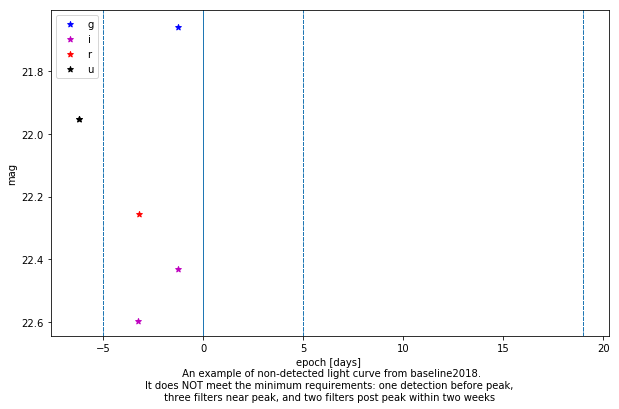

In [37]:
plotlc(df[ (df.lcAboveThresh) & (df.lcN==20)], time_key='lcEpoch', mag_key='lcMags', filter_key='lcFilters', err_key=None, 
       peakEpoch=peakEpoch, nearPeakT=nearPeakT, postPeakT=postPeakT)

plt.xlabel('epoch [days] \n An example of non-detected light curve from baseline2018.\n' + 
           'It does NOT meet the minimum requirements: one detection before peak,\n three filters near peak, and two filters post peak within two weeks ')


## Other opsim database

Other opsim databases can be explored by following the same procedure.

** pontus_2573.db **

In [38]:
opsdb_pontus = db.OpsimDatabase('./opsdb/pontus_2573.db')
# opsdb.fetchPropInfo()

Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<600 for columns ['observationStartMJD', 'fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth']
Found 369875 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<600" constraint now.
monopole: 0.00731512  dipole: lon: 72.7634, lat: -55.7077, amp: 0.00493018
Plotting complete.


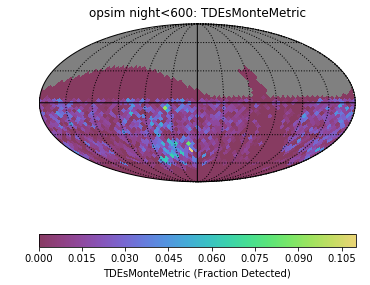

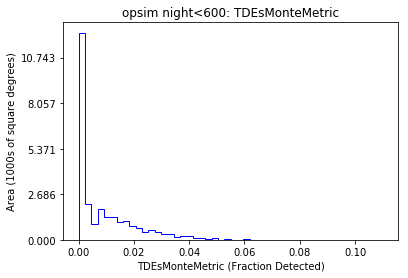

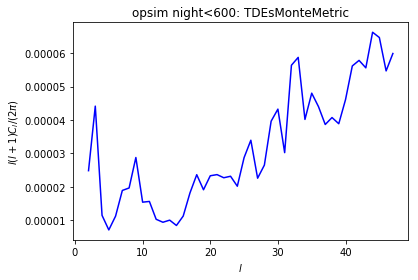

In [35]:
# get skymap by set dataout=False and use HealpixSlicer()
transmetric = TDEsMonteMetric(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                              detectSNR=detectSNR, eventRate=eventRate,
                              epochStart=epochStart, peakEpoch=peakEpoch, 
                              nearPeakT=nearPeakT, postPeakT=postPeakT,
                              nObsTotal= nObsTotal, nObsPrePeak=nObsPrePeak, 
                              nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                              nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                              dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<600'

transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_pontus, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)


light curve for pontus

In [26]:
## get light curve by set dataout=True and use UserPointSlicer()
transmetric = TDEsMonteMetric(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                              detectSNR=detectSNR, eventRate=eventRate,
                              epochStart=epochStart, peakEpoch=peakEpoch, 
                              nearPeakT=nearPeakT, postPeakT=postPeakT,
                              nObsTotal= nObsTotal, nObsPrePeak=nObsPrePeak, 
                              nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                              nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                              dataout=True)
# ra,dec of ipix 
ra = np.array([185.625])
dec = np.array([-32.79716])
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<600 '
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_pontus, outDir=outDir, resultsDb=resultsDb)
group.runAll()

Finish initializing metric
Querying database SummaryAllProps with constraint night<600  for columns ['observationStartMJD', 'fieldRA', 'fieldDec', 'filter', 'fiveSigmaDepth']
Found 369875 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [27]:
# create a DataFrame from the output
output_dict_list = transmetricSky.metricValues.data[0] # 0 means 0th userpoint (ra,dec)
df = pd.DataFrame()
for d_ in output_dict_list:
    df = df.append(pd.DataFrame(d_))

# save to file
df.to_csv('./opsdb/pontus_lc_TDEmc.csv', index=False)
df.head()

,detected,lcAboveThresh,lcEpoch,lcFilters,lcMags,lcMagsStd,lcMjd,lcN,lcSNR,m5,nearPeakCheck,postPeakCheck,prePeakCheck
0,False,False,-20.311782,z,30.072205,5.199085,60417.049826,0,0.008395,23.134771,False,False,True
1,False,False,-20.274039,z,30.044756,5.167441,60417.087569,0,0.008645,23.139236,False,False,True
2,False,False,-11.177037,r,24.304034,0.592197,60426.184572,0,1.378632,22.905229,False,False,True
3,False,False,-11.155671,i,24.635099,0.859960,60426.205938,0,0.827867,22.682576,False,False,True
4,False,False,-10.286493,z,24.567570,0.882993,60427.075116,0,0.796646,22.573309,False,False,True


In [28]:
np.unique( df[df.detected]['lcN'] )

array([34, 85])

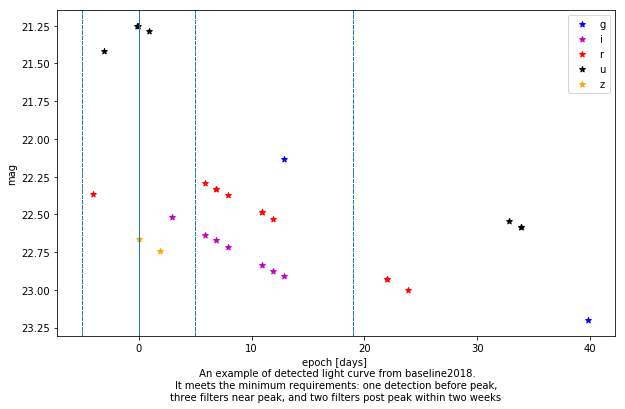

In [31]:
# load from csv
# df = pd.read_csv('./opsdb/baseline2018_lc.csv')

# plot all light curve
# plotlc(df[ (df['lcAboveThresh'])], time_key='expMJD', mag_key='lcMags', filter_key='filters', err_key='lcMagsStd')

# plot a specific light curve
plotlc(df[ (df.lcAboveThresh) & (df.lcN==100)], time_key='lcEpoch', mag_key='lcMags', filter_key='lcFilters', err_key=None, 
       peakEpoch=peakEpoch, nearPeakT=nearPeakT, postPeakT=postPeakT)

plt.xlabel('epoch [days] \n An example of detected light curve from baseline2018.\n' + 
           'It meets the minimum requirements: one detection before peak,\n three filters near peak, and two filters post peak within two weeks ')

